In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf


from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor

# Data science tools
import numpy as np

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [8]:
# define multi-layer perceptron deep neural network model
# network includes two linear layers, one Relu layer, and one dropout layer
class MLP(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()

        self.linear1 = nn.Linear(input_d, hidden_d)
        self.linear2 = nn.Linear(hidden_d, output_d)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

In [9]:
co2_df = pd.read_csv('../datasets/co2-long-term-concentration.csv')
forest_df = pd.read_csv('../datasets/forest-area-km.csv')
land_df = pd.read_csv('../datasets/land-use-over-the-long-term.csv')
temp_df = pd.read_csv('../datasets/annual-temperature-anomalies.csv')
invas_df = pd.read_csv('../datasets/budget-to-manage-invasive-alien-species.csv')
lpi_df = pd.read_csv('../datasets/global-living-planet-index.csv') # target

merge_datasets = MergeDatasets(co2_df, forest_df, land_df, temp_df, invas_df, lpi_df)
merged_df = merge_datasets.merge()

features = ['Year', 'Entity', 'Long-run CO₂ concentration', 'Forest area', 'Land use: Built-up area', 
            'Land use: Grazingland', 'Land use: Cropland', 'Temperature anomaly']

entities = pd.get_dummies(merged_df['Entity'])
X_continuous = merged_df[['Year', 'Long-run CO₂ concentration', 'Forest area', 'Land use: Built-up area', 
                          'Land use: Grazingland', 'Land use: Cropland', 'Temperature anomaly']].values
X = np.hstack((X_continuous, entities.values))

y = merged_df['Living Planet Index'].values.reshape(-1, 1)

In [10]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale labels
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()  # Flatten to 1D array after scaling

# Convert scaled features and labels to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

input_d = X.shape[1]
hidden_d = 64
output_d = 1

model = MLP(input_d, hidden_d, output_d)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=10,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            output = model(data)

            # Loss function
            loss = criterion(output, target)

            # Backward path (backpropagation)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            # _, pred = torch.max(output, dim=1)
            # correct_tensor = pred.eq(target.data.view_as(pred))

            # # Need to convert correct tensor from int to float to average
            # accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # # Multiply average accuracy times the number of examples in batch
            # train_acc += accuracy.item() * data.size(0)

            # # Track training progress
            # print(
            #     f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
            #     end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    # data, target = data.cuda(), target.cuda()

                    # Forward path
                    output = model(data)

                    # Validation loss computation
                    loss = criterion(output, target)

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history, columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss'])
    return model, history

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

# Initialize the model
input_d = X.shape[1]  # Adjust the input dimension to match feature number
hidden_d = 64  # Hidden dimension, can be tuned
output_d = 1   # Since it's regression, the output dimension is 1

model = MLP(input_d, hidden_d, output_d)
criterion = nn.MSELoss()  # MSE is typically used for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the file name to save the model
save_file_name = 'best_model.pt'

# Train the model
trained_model, history = train(model=model,
                               criterion=criterion,
                               optimizer=optimizer,
                               train_loader=train_loader,
                               valid_loader=valid_loader,
                               save_file_name=save_file_name,
                               max_epochs_stop=3,
                               n_epochs=50,
                               print_every=1)

# Compute the MSE
# This will be computed as part of the training function in your current setup, printed out, and saved in 'history'
print(f"Final Training MSE: {history['train_loss'].iloc[-1]}")
print(f"Final Validation MSE: {history['valid_loss'].iloc[-1]}")

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.0857 	Validation Loss: 0.7286

Epoch: 1 	Training Loss: 1.0149 	Validation Loss: 0.6543

Epoch: 2 	Training Loss: 0.8503 	Validation Loss: 0.5855

Epoch: 3 	Training Loss: 0.7896 	Validation Loss: 0.5238

Epoch: 4 	Training Loss: 0.6954 	Validation Loss: 0.4665

Epoch: 5 	Training Loss: 0.6343 	Validation Loss: 0.4147

Epoch: 6 	Training Loss: 0.5203 	Validation Loss: 0.3698

Epoch: 7 	Training Loss: 0.5188 	Validation Loss: 0.3225

Epoch: 8 	Training Loss: 0.4299 	Validation Loss: 0.2805

Epoch: 9 	Training Loss: 0.3949 	Validation Loss: 0.2384

Epoch: 10 	Training Loss: 0.3879 	Validation Loss: 0.1988

Epoch: 11 	Training Loss: 0.3421 	Validation Loss: 0.1627

Epoch: 12 	Training Loss: 0.2876 	Validation Loss: 0.1322

Epoch: 13 	Training Loss: 0.2491 	Validation Loss: 0.1077

Epoch: 14 	Training Loss: 0.2353 	Validation Loss: 0.0888

Epoch: 15 	Training Loss: 0.1937 	Validation Loss: 0.0692

Epoch: 16 	Training Loss: 0.1597

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

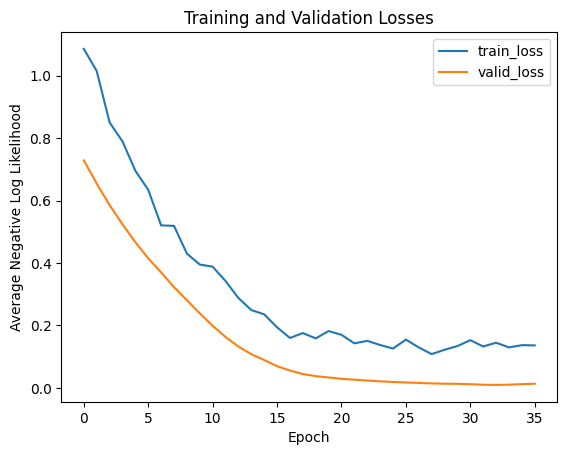

In [23]:
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')